In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import json
import sys

In [3]:
df = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')
df.head()

,uniprot,pdb,region_1,region_2,complex_rmsd,percent_region_1,percent_region_2,2_aligned,2_comp,conformation,state,organism,date,notes
0,A0A0R4I961,6gtv,155-279,3-147,1.45,100.0,100.0,1.673,1.135,Open,Active,Escherichia coli F18+,['2018-06-19'],NaN
1,A0A0R4I961,6gtz,155-279,3-147,1.631,100.0,100.0,1.648,3.014,Open,Active,Escherichia coli F18+,['2018-06-19'],NaN
2,A0A0R4I961,6gu0,155-279,3-147,2.105,100.0,100.0,1.788,4.298,Open,Active,Escherichia coli F18+,['2018-06-19'],NaN
3,B5XAZ0,7bfk,116-120,1-115,4.781,100.0,83.478261,2.6,0.965,Closed,Autoinhibited,Salmo salar,['2021-01-04'],NaN
4,B5XAZ0,7bfl,116-120,1-115,2.591,100.0,79.130435,2.76,0.807,Closed,Autoinhibited,Salmo salar,['2021-01-04'],NaN


In [4]:
plt.style.use('ggplot')

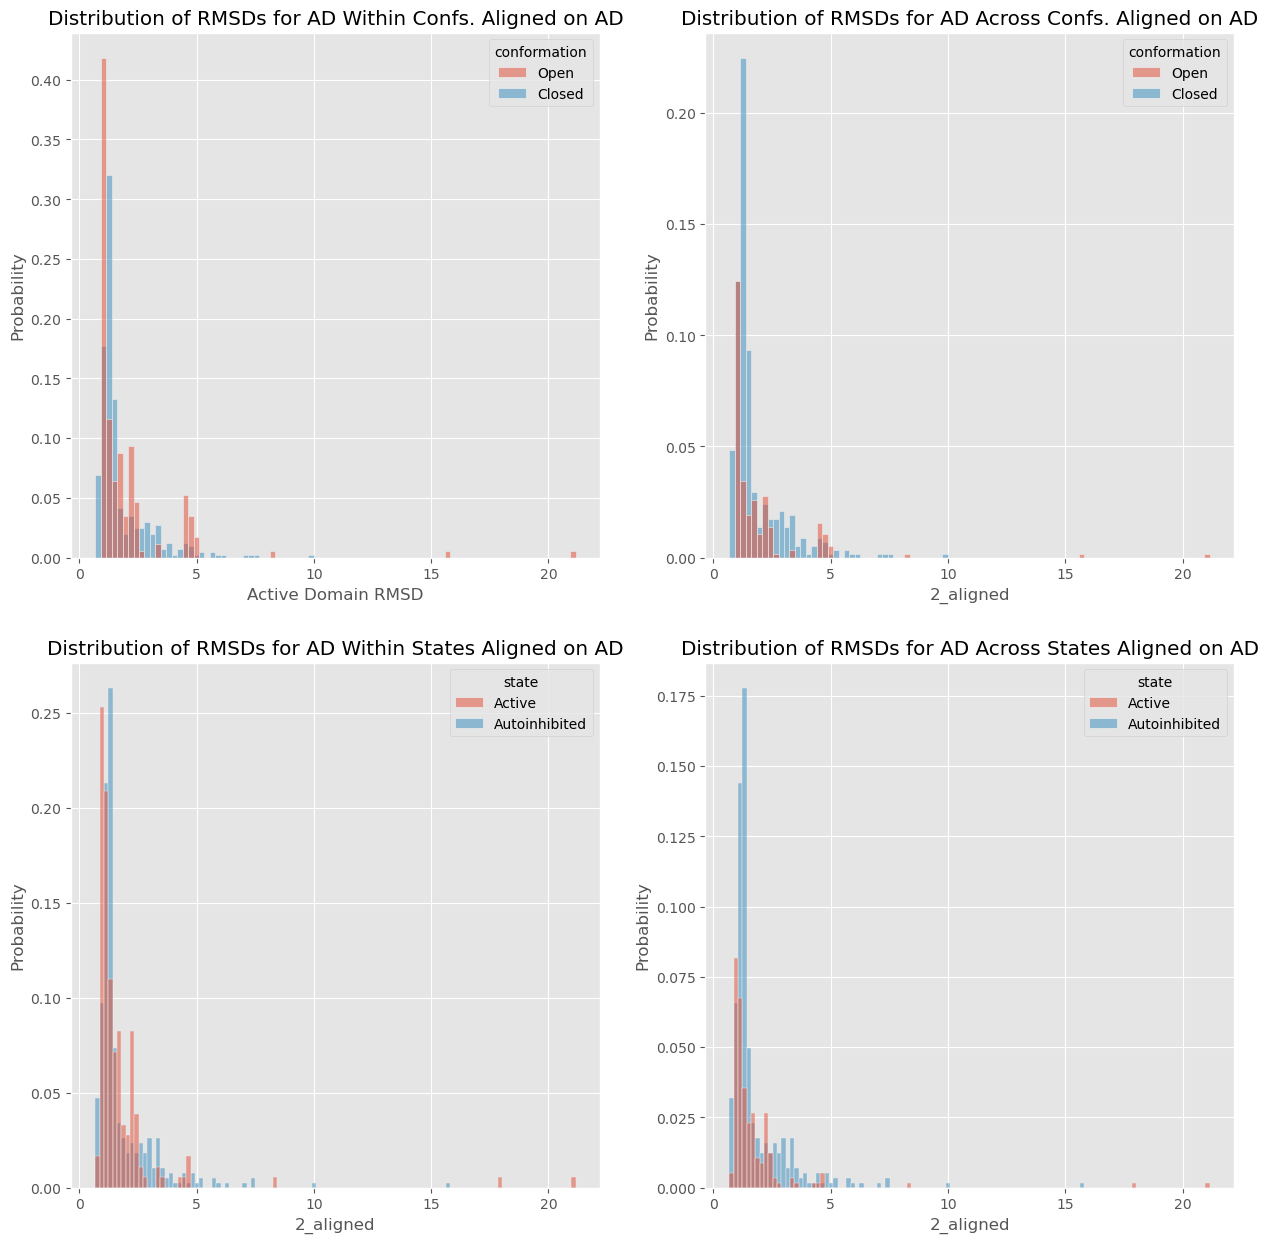

In [5]:
'''
Histograms of RMSDs for region 2 when aligned on region 2. 
'''

df_open = df[df['conformation'] == 'Open']
df_closed = df[df['conformation'] == 'Closed']

'''
Within each conformation, plot the distribution of the 2_aligned values. This shows us the distribution of RMSDS as probabilities within each conformation (i.e. how many
of the RMSDs for open conformations are between 0 and 1, how many are between 1 and 2, etc.)
'''
f, ax = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)
sns.histplot(data=df, x='2_aligned', hue='conformation', stat='probability', common_norm=False, ax=ax[0][0])
ax[0][0].set_title('Distribution of RMSDs for AD Within Confs. Aligned on AD')
ax[0][0].set_xlabel('Active Domain RMSD')

'''
Across both conformations, plot the distribution of the 2_aligned values. This shows us the distribution of RMSDs as probabilities across both conformations,
which also shows their relative abundance to each other. 
'''
sns.histplot(data=df, x='2_aligned', hue='conformation', stat='probability', ax=ax[0][1])
ax[0][1].set_title('Distribution of RMSDs for AD Across Confs. Aligned on AD')

'''
Within each state, plot the distribution of the 2_aligned values. See the first graph for conceptual explanation.
'''
sns.histplot(data=df, x='2_aligned', hue='state', stat='probability', common_norm=False, ax=ax[1][0])
ax[1][0].set_title('Distribution of RMSDs for AD Within States Aligned on AD')

'''
Across both states, plot the distribution of the 2_aligned values. See the second graph for conceptual explanation.
'''
sns.histplot(data=df, x='2_aligned', hue='state', stat='probability', ax=ax[1][1])
ax[1][1].set_title('Distribution of RMSDs for AD Across States Aligned on AD')

plt.savefig('./project_pipeline/data/figures/2_aligned.png')
plt.show()

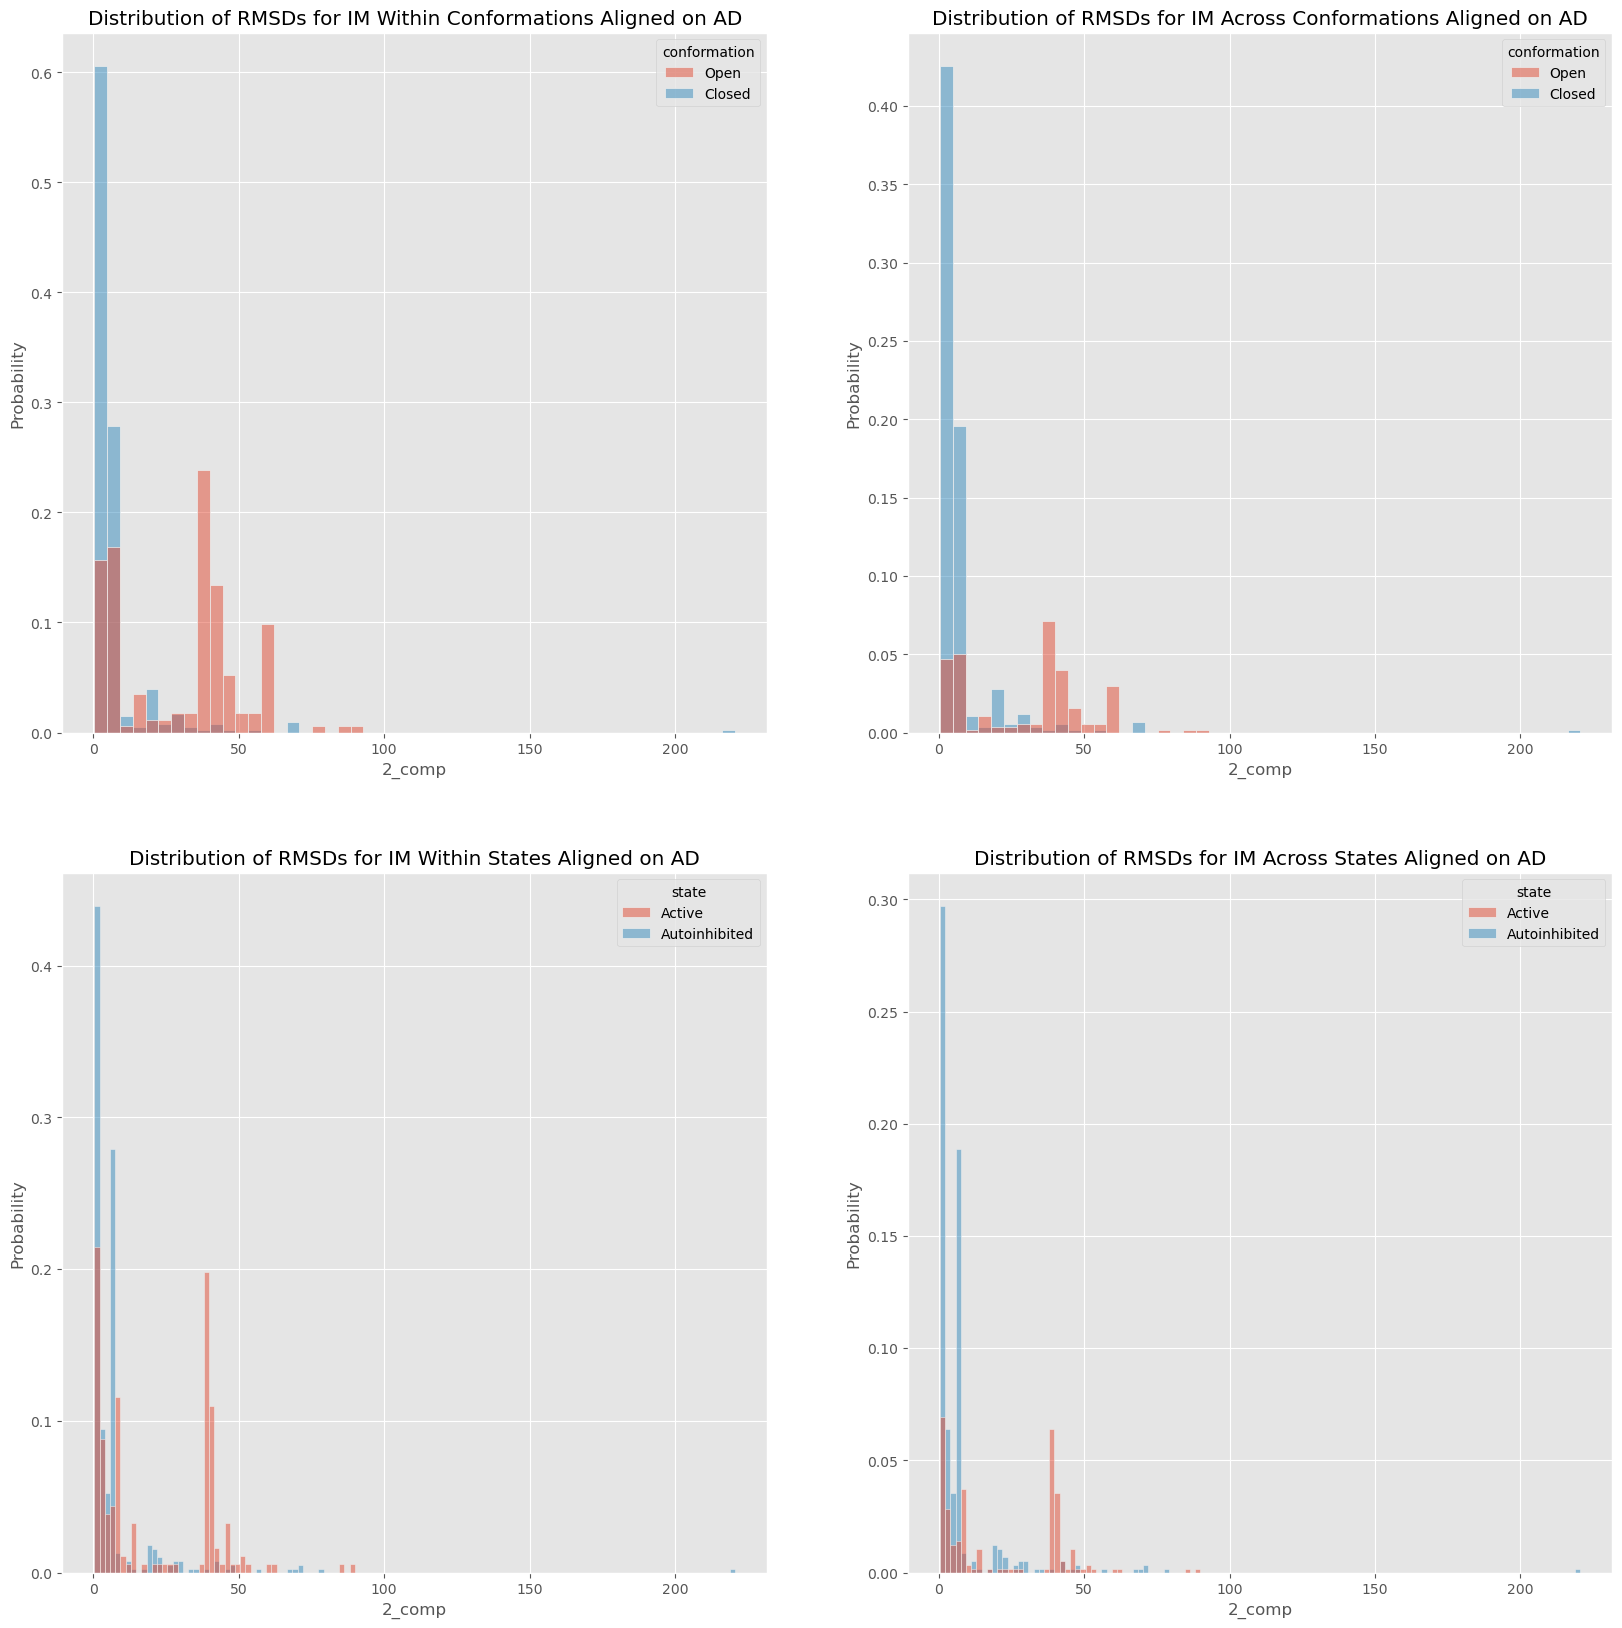

In [6]:
'''
Histograms of RMSDs for region 1 when aligned on region 2
'''

'''
Within each conformation, plot the distribution of the 2_comp values
'''
f, ax = plt.subplots(figsize=(20, 20), nrows=2, ncols=2)
sns.histplot(data=df, x='2_comp', hue='conformation', stat='probability', common_norm=False, ax=ax[0][0])
ax[0][0].set_title('Distribution of RMSDs for IM Within Conformations Aligned on AD')

'''
Across both conformations, plot the distribution of the 2_aligned values
'''
sns.histplot(data=df, x='2_comp', hue='conformation', stat='probability', ax=ax[0][1])
ax[0][1].set_title('Distribution of RMSDs for IM Across Conformations Aligned on AD')

'''
Within each state, plot the distribution of the 2_aligned values
'''
sns.histplot(data=df, x='2_comp', hue='state', stat='probability', common_norm=False, ax=ax[1][0])
ax[1][0].set_title('Distribution of RMSDs for IM Within States Aligned on AD')

'''
Across both states, plot the distribution of the 2_aligned values
'''
sns.histplot(data=df, x='2_comp', hue='state', stat='probability', ax=ax[1][1])
ax[1][1].set_title('Distribution of RMSDs for IM Across States Aligned on AD')


plt.savefig('./project_pipeline/data/figures/2_comp.png')
plt.show()

In [7]:
'''
Summary statistics
'''

df.agg({'2_aligned': ['min', 'max', 'median', 'mean', 'skew'],
        '2_comp': ['min', 'max', 'median', 'mean', 'skew']})

,2_aligned,2_comp
min,0.683000,0.404000
max,21.158000,220.629000
median,1.367000,3.572500
mean,1.923658,12.104697
skew,5.374823,3.058221


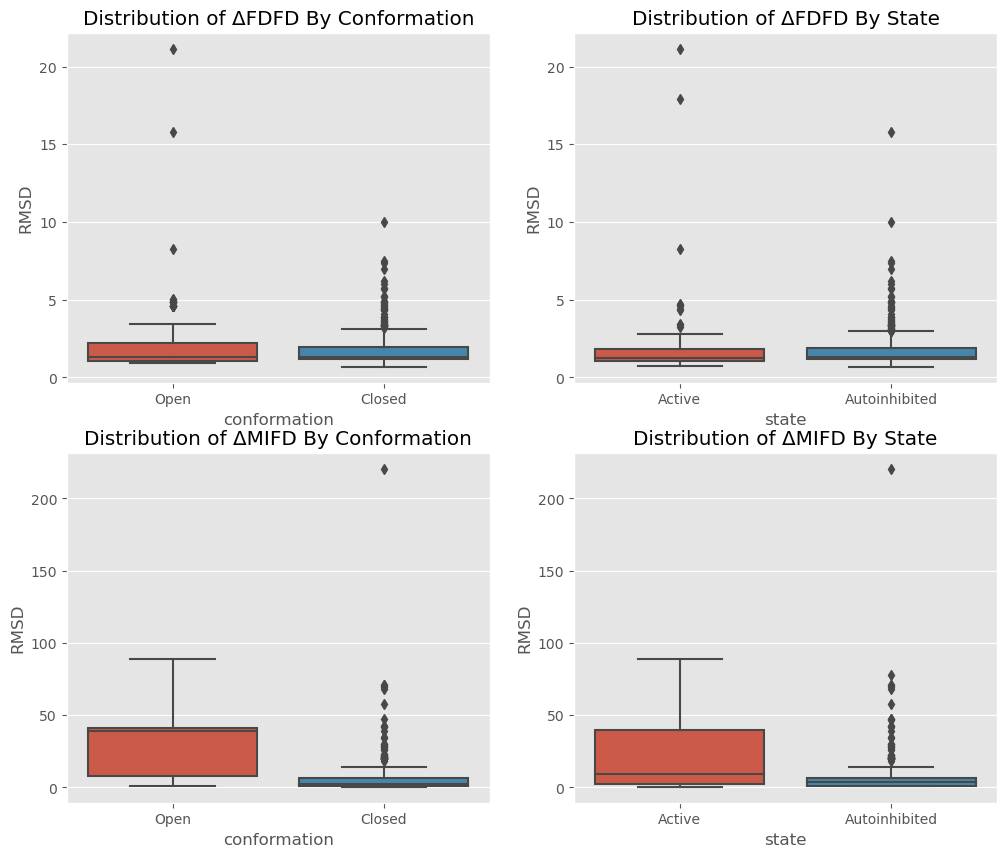

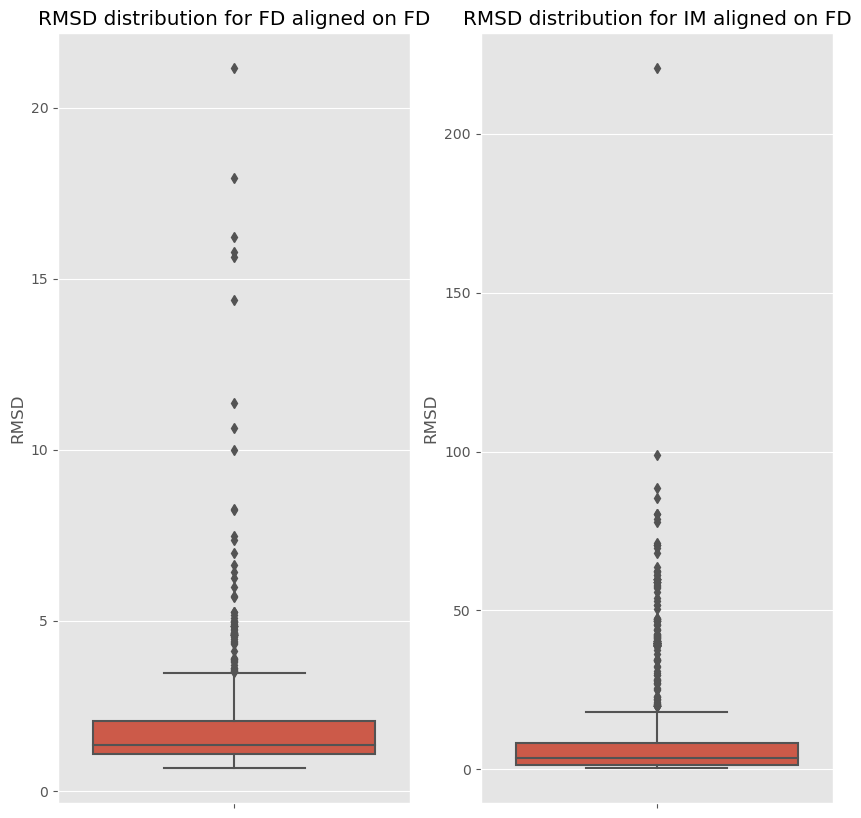

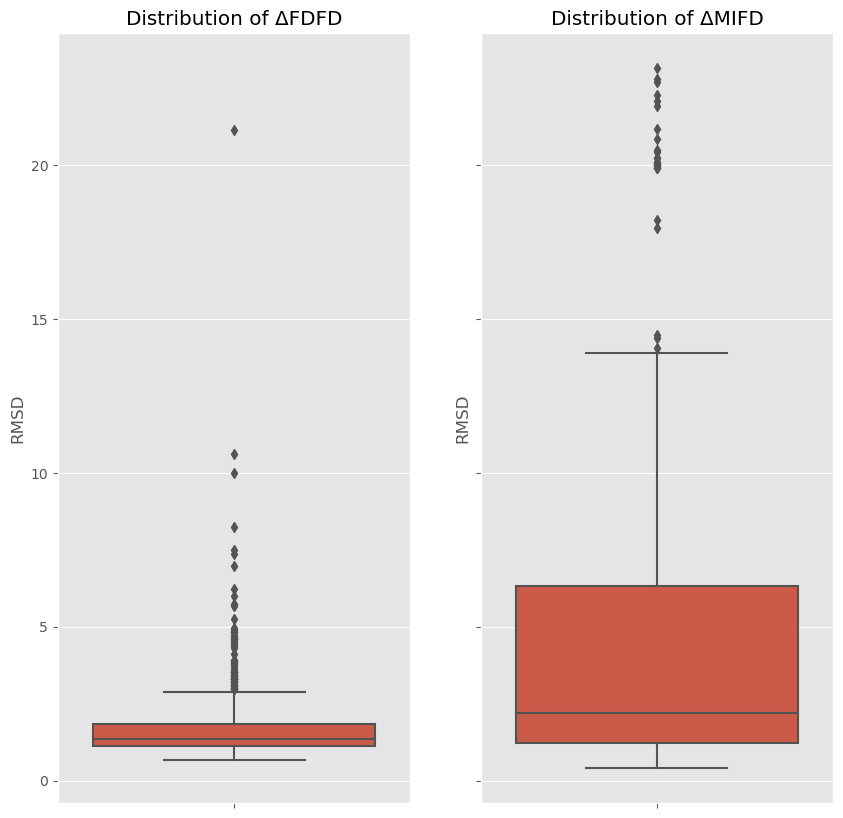

In [8]:
'''
Box plots of the RMSDs
'''

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))


sns.boxplot(data=df, x='conformation', y='2_aligned', ax=ax[0][0])
ax[0][0].set_title('Distribution of ΔFDFD By Conformation')
ax[0][0].set_ylabel('RMSD')

sns.boxplot(data=df, x='state', y='2_aligned', ax=ax[0][1])
ax[0][1].set_title('Distribution of ΔFDFD By State')
ax[0][1].set_ylabel('RMSD')

sns.boxplot(data=df, x='conformation', y='2_comp', ax=ax[1][0])
ax[1][0].set_title('Distribution of ΔMIFD By Conformation')
ax[1][0].set_ylabel('RMSD')

sns.boxplot(data=df, x='state', y='2_comp', ax=ax[1][1])
ax[1][1].set_title('Distribution of ΔMIFD By State')
ax[1][1].set_ylabel('RMSD')

plt.savefig('./project_pipeline/data/figures/distribution_per_region.png')
plt.show()


f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
sns.boxplot(data=df, y='2_aligned', ax=ax[0])
ax[0].set_title('RMSD distribution for FD aligned on FD')
ax[0].set_ylabel('RMSD')

sns.boxplot(data=df, y='2_comp', ax=ax[1])
ax[1].set_title('RMSD distribution for IM aligned on FD')
ax[1].set_ylabel('RMSD')

plt.savefig('./project_pipeline/data/figures/no_subcategorization.png')

# Remove outlier
df = df[df['2_comp'] <= 25]

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10), sharey=True)
sns.boxplot(data=df, y='2_aligned', ax=ax[0])
ax[0].set_title('Distribution of ΔFDFD')
ax[0].set_ylabel('RMSD')

sns.boxplot(data=df, y='2_comp', ax=ax[1])
ax[1].set_title('Distribution of ΔMIFD')
ax[1].set_ylabel('RMSD')

plt.savefig('./project_pipeline/data/figures/no_subcategorization_no_outliers.png')

671


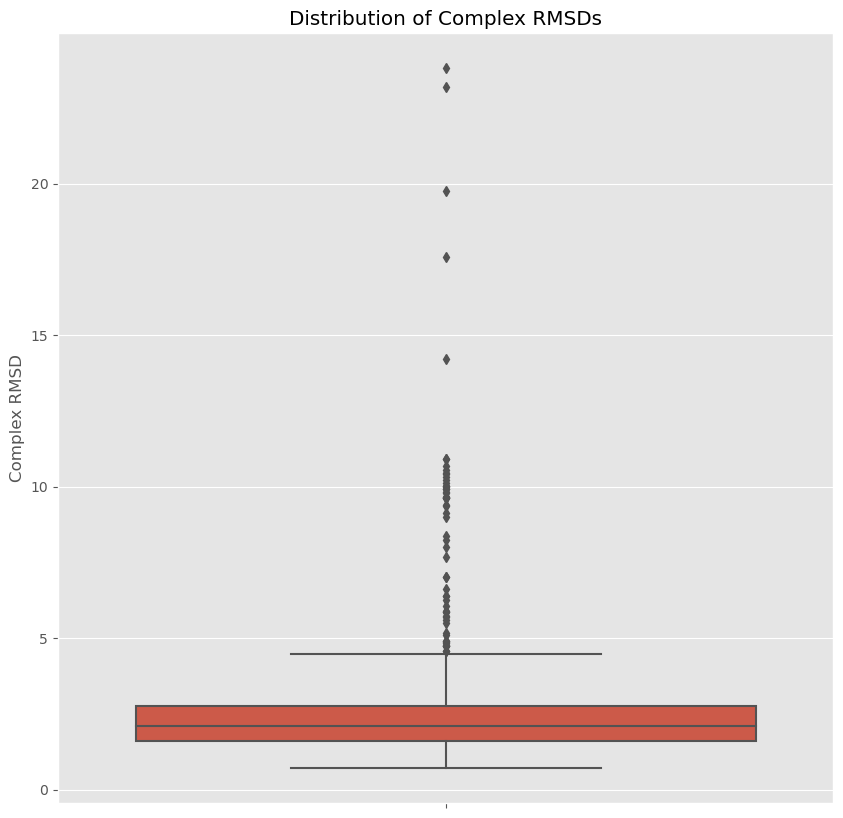

In [9]:
f, ax = plt.subplots(figsize=(10, 10))

sns.boxplot(data=df, y='complex_rmsd', ax=ax)
ax.set_ylabel('Complex RMSD')
ax.set_title('Distribution of Complex RMSDs')
plt.savefig('./project_pipeline/data/figures/complex_rmsd.png')
print(len(df))

In [17]:
'''
Determine the distributions of open/closed and active/autoinhibited proteins in the PDB
'''

df = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

# Number of pdb files
print('Number of pdb files: ' + str(len(df)))

# Number of PDB files with state or conformation information
df = df.dropna(subset=['state', 'conformation'])
print('Dropping rows gives us: ' + str(len(df)) + ' files and ' + str(len(df.groupby(['uniprot']).size())) + ' proteins')

# Organize by state and conformation
pdb_groups = df.groupby(['state', 'conformation']).size()

pdb_df = pdb_groups.to_frame(name='PDB').reset_index()
pdb_df.head()


Number of pdb files: 824
Dropping rows gives us: 551 files and 92 proteins


,state,conformation,PDB
0,Active,Closed,39
1,Active,Open,141
2,Autoinhibited,Closed,365
3,Autoinhibited,Open,6


Number of pdb files: 824
Dropping rows gives us: 551 files and 92 proteins
123
Greater than 15:  conformation  state        
Closed        Autoinhibited    10
Open          Active            5
              Autoinhibited     1
dtype: int64
Less than 15 conformation  state        
Closed        Active           10
              Autoinhibited    47
Open          Active           11
              Autoinhibited     1
dtype: int64


,conformation,state,greater_15
0,Closed,Autoinhibited,10
1,Open,Active,5
2,Open,Autoinhibited,1


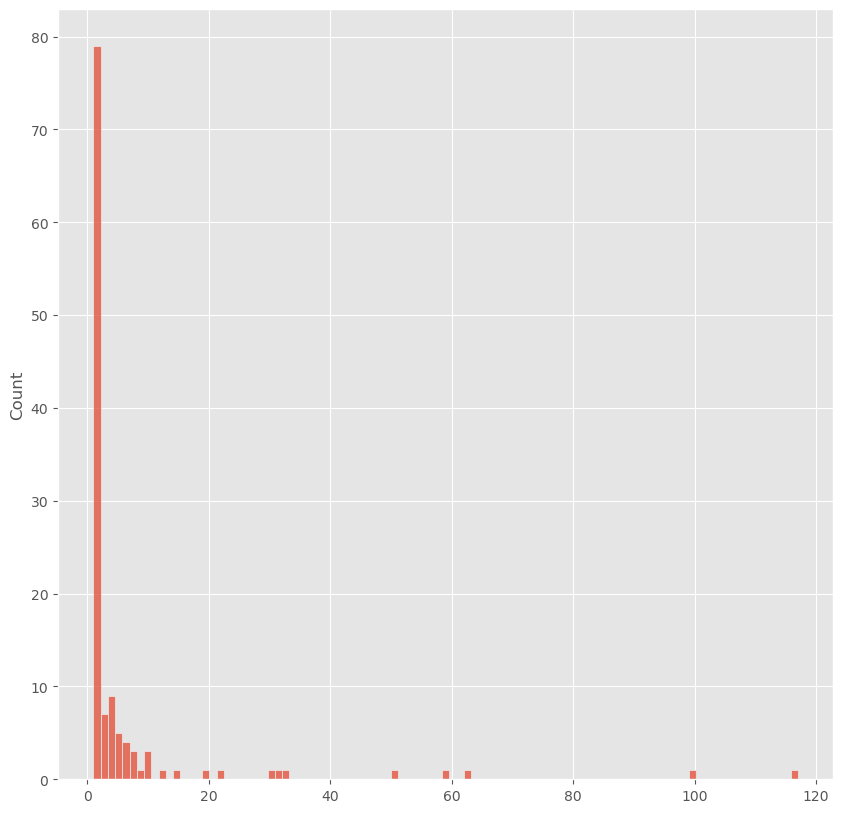

In [16]:
'''
Determine the state and conformation of each AlphaFold2 structure
'''

df = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')

# Number of pdb files
print('Number of pdb files: ' + str(len(df)))

# If we were to drop any rows without state or conformation information, how many proteins would we have?
df_drop = df.dropna(subset=['conformation', 'state'])
print('Dropping rows gives us: ' + str(len(df_drop)) + ' files and ' + str(len(df_drop.groupby(['uniprot']).size())) + ' proteins')

# Count the number of unique uniprot ids within the original dataframe
num_proteins = df.groupby(['uniprot']).size()

# Find the pdb id with the lowest 2_comp value for each uniprot id. We use this as a proxy for the AlphaFold2 structure's conformation and state
df = df.sort_values(by=['uniprot', '2_comp'])
df = df.drop_duplicates(subset=['uniprot'], keep='first')

df = df.dropna(subset=['conformation', 'state'])

# What do the groups look like for 2_comp values greater than 15?
df_greater = df[df['2_comp'] > 15]
num_combos_greater = df_greater.groupby(['conformation', 'state']).size()

# Ignore any structures that have a 2_comp value greater than 15
df_lesser = df[df['2_comp'] <= 15]
# Find the number of structures for each conformation and state
num_combos = df_lesser.groupby(['conformation', 'state']).size()


print(len(num_proteins))
print('Greater than 15: ', num_combos_greater)
print('Less than 15', num_combos)

greater_15 = num_combos_greater.to_frame(name='AF_PDB_nomatch').reset_index()
less_15 = num_combos.to_frame(name='AF_PDB_match').reset_index()
# Save the dataframe
# df.to_csv('./project_pipeline/data/deepmind_conf_state.tsv', sep='\t', index=False)

# num_proteins.to_csv('./project_pipeline/data/num_proteins.tsv', sep='\t')

# Plot a histogram of the number of files per uniprot id
f, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=num_proteins, ax=ax)

52 conformation  state        
Closed        Active            4
              Autoinhibited    14
Open          Active            5
dtype: int64


<Axes: ylabel='Count'>

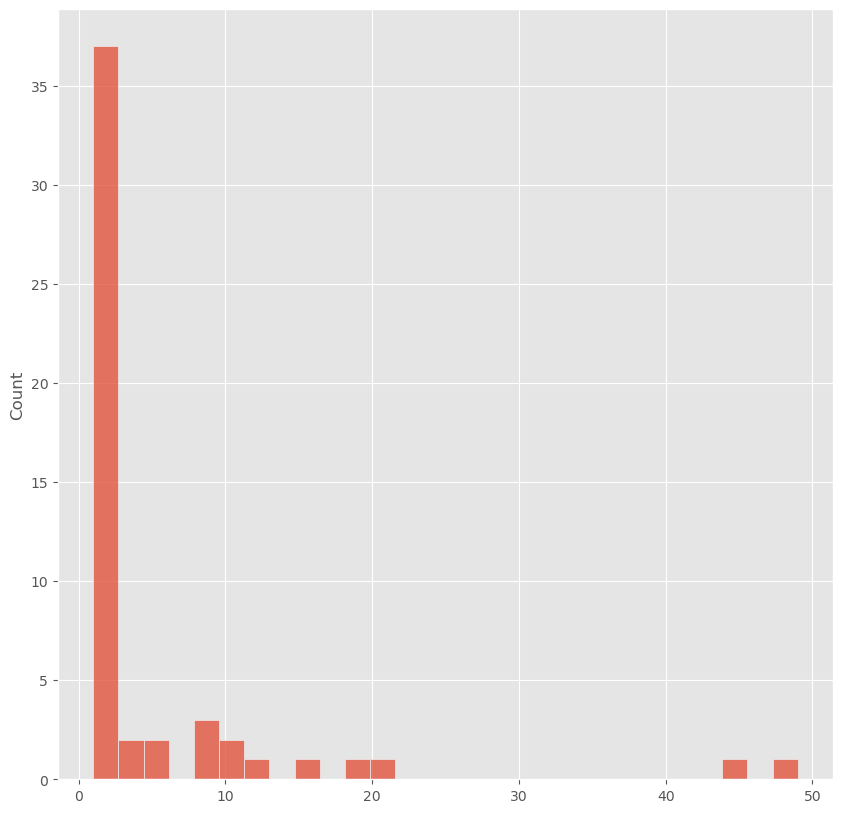

In [12]:
'''
Repeat the above steps, but for structures deposited after April 30th, 2018
'''

# Clean up the dates for the next step
df = pd.read_csv('./project_pipeline/data/classified_files_3.tsv', sep='\t').astype('object')
df['date'] = df['date'].str.strip('['']')

# Convert the date column to datetime objects
df['date'] = pd.to_datetime(df['date'])

# Filter out any structures deposited before March 30th, 2018
df = df[df['date'] > '2018-04-30']

# Count the number of unique uniprot ids within the original dataframe
num_proteins = df.groupby(['uniprot']).size()

# Find the pdb id with the lowest 2_comp value for each uniprot id. We use this as a proxy for the AlphaFold2 structure's conformation and state
df = df.sort_values(by=['uniprot', '2_comp'])
df = df.drop_duplicates(subset=['uniprot'], keep='first')

# Ignore any structures that have a 2_comp value greater than 15
df = df[df['2_comp'] <= 15]

# Find the number of structures for each conformation and state
num_combos = df.groupby(['conformation', 'state']).size()

print(len(num_proteins), num_combos)

# Save the dataframe
# df.to_csv('./project_pipeline/data/deepmind_conf_state_post_2018.tsv', sep='\t', index=False)

# num_proteins.to_csv('./project_pipeline/data/num_proteins_post_2018.tsv', sep='\t') 

# Plot a histogram of the number of files per uniprot id
f, ax = plt.subplots(figsize=(10, 10))
sns.histplot(data=num_proteins, ax=ax)
